# Differential abundance - Extended

The notebook on ['Differential abundance - Basics'](https://microucph.github.io/amplicon_data_analysis/html/da.html) only explained two different methods for doing DA analysis. There are however many different methods, and choosing the best is not a simple task. Benchmark studies have shown that different methods have different strengths, and the choice of method therefore in part relies on the specific dataset in question. The [DAtest package](https://github.com/russel88/datest) tries to solve this problem by testing a lot if different methods on your own dataset and provide some statistics on their performance. The details can be found in the [wiki](https://github.com/russel88/datest/wiki), but the basic idea is that the predictor of interest (e.g. treatment/control) is shuffled. Then for some random features (ASVs) we multiply the abundance with some number (e.g. 5), but only for the shuffled treatment samples. We then apply the diferent DA methods and check if they can find the ASVs which were increased in abundance for the shuffled predictor. The predictor is shuffled to remove any true effect present in the dataset. This procedure is repeated several times, by default 20, to evaluate the consistency of the performance.

Another feature of DAtest is that it is easy to run several different methods and compare their output. One could for example run 3 methods known to perform well, and then use their combined results for a less biased DA analysis.

In [1]:
# Load phyloseq object and phyloseq package
library(phyloseq)
load("../data/physeq.RData")

In [2]:
library(DAtest)

DAtest version 2.7.18


# Contents
* [preDA](#pre)
* [testDA](#test)
* [allDA](#all)

## preDA<a class="anchor" id="pre"></a>

As explained in the [Basics notebook](https://microucph.github.io/amplicon_data_analysis/html/da.html), we always want to prepare our data first, especially by pruning low abundant taxa

#### In R:

In [3]:
# Agglomorate to Genus level
phy_genus <- tax_glom(phy, "Genus")

# Only keep genera present in at least 10 samples
phy_genus_pre <- preDA(phy_genus, min.samples = 10)

204 features grouped as 'Others' in the output


## testDA<a class="anchor" id="test"></a>
testDA runs all the different methods and compares them by their empirical power (ability to detect spiked features), their False Discovery Rate (FDR, fraction of significant features which are false positives), and their AUC (area under the ROC curve, ability to rank the features from most to least associated to the predictor). This is all combined into a score, which ranks the different methods. The method with the highest score should perform best.

It is important to note that DAtest assumes that most features are NOT associated with the predictor. Therefore, if for example your control and treatment samples are very different (clearly separated in a PCoA ordination), then only the False Positive Rate (FPR) can be used to weed out bad methods, but the other measures are not trustworthy.


#### In R:

In [4]:
res <- testDA(phy_genus_pre, predictor = "Delivery")

Running on 7 cores
predictor is assumed to be a categorical variable with 2 levels: Sectio, Vaginal


Spikeing...
Testing 29 methods 20 times each...
  |======================================================================| 100%


ds2x, erq2, ere2 were excluded due to failure


In [5]:
summary(res)

                     Method  AUC  FPR  FDR Power Score Score.5% Score.95%  
        MgSeq Feature (msf) 0.81 0.04 0.00  0.13  0.04    -0.48      0.09 *
 DESeq2 man. geoMeans (ds2) 0.69 0.04 0.00  0.13  0.03    -1.00      0.03 *
               t-test (ttt) 0.73 0.05 0.00  0.07  0.02    -0.49      0.03 *
               Wilcox (wil) 0.55 0.05 0.00  0.03  0.00    -0.50      0.01 *
           Log t-test (ltt) 0.59 0.05 0.00  0.00  0.00     0.00      0.01 *
        ALDEx2 t-test (adx) 0.57 0.01 0.00  0.00  0.00     0.00      0.00 *
          LIMMA - ALR (lia) 0.72 0.07 0.00  0.00  0.00    -1.06      0.03 *
            Log LIMMA (lli) 0.59 0.05 0.00  0.00  0.00    -1.00      0.00 *
        t-test - Rank (ttr) 0.52 0.05 0.00  0.00  0.00    -1.00      0.00 *
         t-test - ALR (tta) 0.72 0.07 0.00  0.00  0.00    -0.99      0.03 *
         t-test - CLR (ttc) 0.60 0.06 0.00  0.00  0.00    -0.66      0.01 *
         Log t-test2 (ltt2) 0.64 0.06 0.00  0.00  0.00    -0.36      0.02 *
         Log

MetagenomeSeq Feature (msf) method appears to be the best. However, the bootstrapped confidence interval (Score.5% and Score.95%) show that many methods are indistugishiable from msf (\*). 

Let's run the msf method:

In [6]:
res_msf <- DA.msf(phy_genus_pre, predictor = "Delivery")

Default value being used.


In [7]:
res_msf[res_msf$pval.adj <= 0.05, ]

,Feature,+samples in group 0,+samples in group 1,counts in group 0,counts in group 1,logFC,se,pval,adjPvalues,pval.adj,ordering,Method,Kingdom,Phylum,Class,Order,Family,Genus,Species
4,08b21f8171b35ef001832ba1df9b8fbc,69,56,232864,81668,-1.4441416,0.3083843,2.828047e-06,1.583706e-04,1.583706e-04,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,NA
9,107063e8453bf94891c4d7a17b00af07,4,17,319,9511,2.8937922,0.9705050,2.866166e-03,2.140070e-02,2.140070e-02,Vaginal>Sectio,MgSeq Feature (msf),Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Veillonellaceae,Veillonella_A,NA
10,11d9c9ed1d2d58a9cb0bbcdc93aa3e55,3,26,41,27727,4.7344448,1.2675331,1.875924e-04,3.082105e-03,3.082105e-03,Vaginal>Sectio,MgSeq Feature (msf),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus_H,NA
24,333fc718c6bccdbf0fd4e4f84d0dd38e,34,35,143352,11880,-2.6786034,0.6048946,9.501622e-06,3.547272e-04,3.547272e-04,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,NA
29,44d9fc4de8898b6c82c69654435a9f0b,32,25,26682,6755,-1.8019516,0.5644906,1.412069e-03,1.757241e-02,1.757241e-02,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,NA
30,45c4f6f269ec95ff0c8dd594104519e9,27,17,159140,40544,-1.7996174,0.5901451,2.292617e-03,2.139776e-02,2.139776e-02,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Citrobacter,NA
48,6dbcf153b0182c45e43924e6a0814551,9,2,378,9,-3.8580086,1.3623484,4.627506e-03,3.092891e-02,3.092891e-02,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-354,NA
50,705da2e88a1aaa0c02b27eab4a642b72,1,14,14,7183,0.9738801,0.2600936,1.808657e-04,3.082105e-03,3.082105e-03,Vaginal>Sectio,MgSeq Feature (msf),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Morganella,NA
53,72bda5561e865a5539c4f19f992ee830,54,38,117888,49799,-1.2485314,0.4173685,2.776685e-03,2.140070e-02,2.140070e-02,Sectio>Vaginal,MgSeq Feature (msf),Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Ruminococcus_B,NA
64,87c2912f70537a375ec52d2e37479534,11,33,1086,33112,2.4404307,0.7799554,1.754404e-03,1.882993e-02,1.882993e-02,Vaginal>Sectio,MgSeq Feature (msf),Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,Erysipelatoclostridium,NA


Lots of significant ones!

### Troubleshoot
If the best Score among the methods is 0 (zero), then none of the methods are good enough to detect anything in your dataset. One problem could be that the predictor you are testing has too large an effect, in which case you should only use testDA to remove methods which have a too high FPR. You could also re-run testDA with a higher effectSize, which should make it easier for the methods to detect differentially abundant features.

## allDA<a class="anchor" id="all"></a>
allDA runs the different methods on the actual dataset. This way you can easily compare the different methods. Let's try it out.

In [8]:
res_all <- allDA(phy_genus_pre, predictor = "Delivery")

Running on 7 cores
predictor is assumed to be a categorical variable with 2 levels: Sectio, Vaginal


Running 29 methods...
  |======================================================================| 100%

ds2x, erq2, ere2 were excluded due to failure


An easy comparison is by creating Euler (Venn) diagrams of features which are found significant. 

Let's try to create a diagram with 3 best methods:

Registered S3 method overwritten by 'eulerr':
  method    from  
  plot.venn gplots


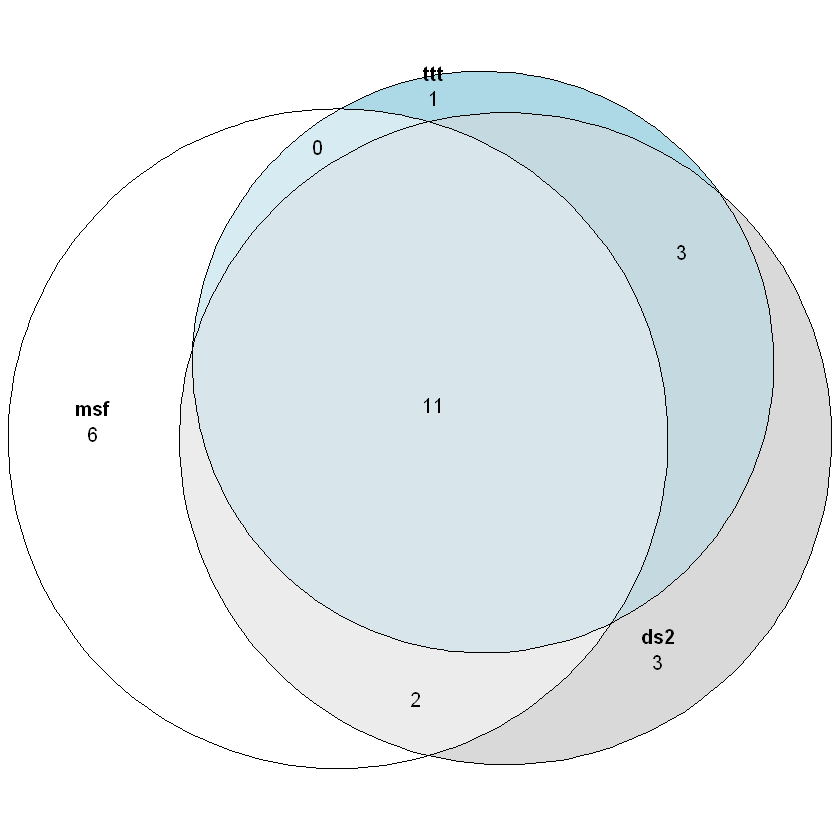

In [9]:
vennDA(res_all, tests = c("msf", "ds2", "ttt"))

The 11 features found significant by all 3 methods might be truly differentially abundant, but let's ensure that the sign of the log fold change is similar:

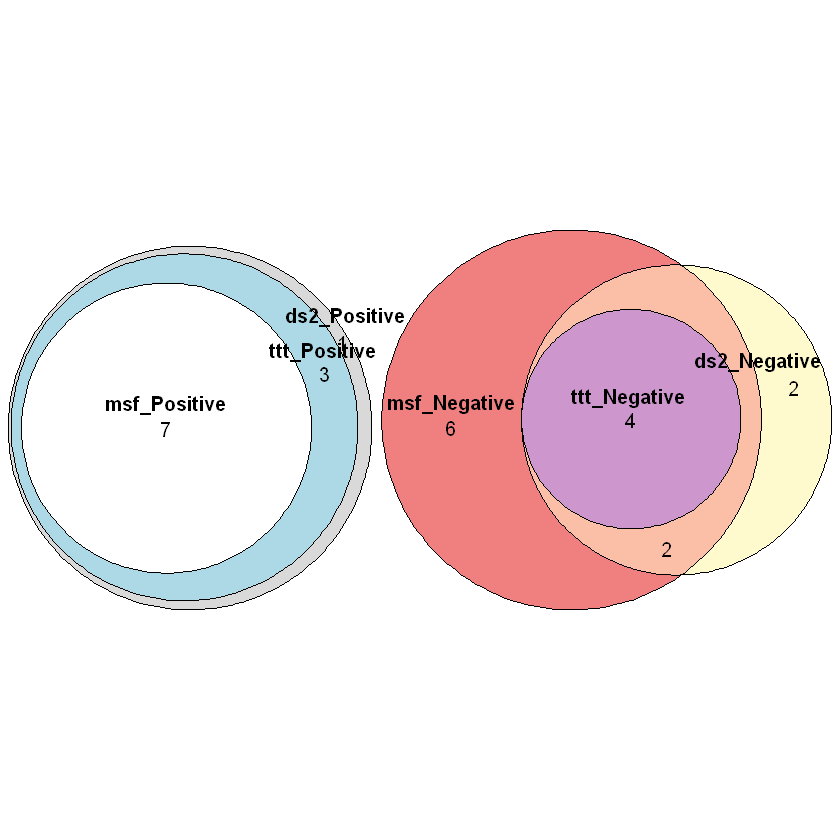

In [10]:
vennDA(res_all, tests = c("msf", "ds2", "ttt"), split = TRUE)

Looks good! 7 features have a positive log fold change with all 3 methods, and 4 features have a negative  log fold change with all 3 methods. If the signs were not matching, then we would not know in which group the features have the highest abundance.